# Implementation of Softmax Regression from Scratch

In [1]:
import d2l
from mxnet import autograd, np, npx, gluon
from IPython import display
npx.set_np()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

Initialize model parameters.

In [2]:
num_inputs = 784
num_outputs = 10

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)

W.attach_grad()
b.attach_grad()

The softmax operator.

In [3]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # The broadcast mechanism is applied here

X = np.random.normal(size=(2, 5))
X_prob = softmax(X)
X_prob.shape, X_prob.sum(axis=1)

((2, 5), array([1.0000001, 1.       ]))

The model

In [4]:
def net(X):
    return softmax(np.dot(X.reshape((-1, num_inputs)), W) + b)

The loss function

In [5]:
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y])

Classification accuracy

In [6]:
def accuracy(y_hat, y):
    return float((y_hat.argmax(axis=1) == y.astype('float32')).sum())

def evaluate_accuracy(net, data_iter):
    metric = d2l.Accumulator(2) # num_corrected_examples, num_examples
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

evaluate_accuracy(net, test_iter)

0.0925

Training for one epoch.

In [7]:
def train_epoch_ch3(net, train_iter, loss, updater):
    metric = d2l.Accumulator(3) # train_loss_sum, train_acc_sum, num_examples
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X, y in train_iter:
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    # Return training loss and training accuracy
    return metric[0]/metric[2], metric[1]/metric[2]

The whole training function.

In [8]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    trains, test_accs = [], []
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            ylim=[0.3, 0.9],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

Training

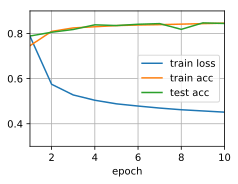

In [9]:
num_epochs, lr = 10, 0.1
updater = lambda batch_size: d2l.sgd([W, b], lr, batch_size)
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

Prediction

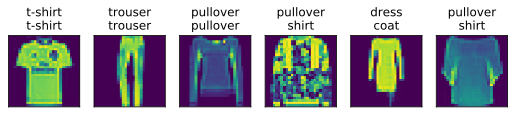

In [10]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true+'\n'+ pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)